Fitted lifetime: 3.034 ± 0.156 μs


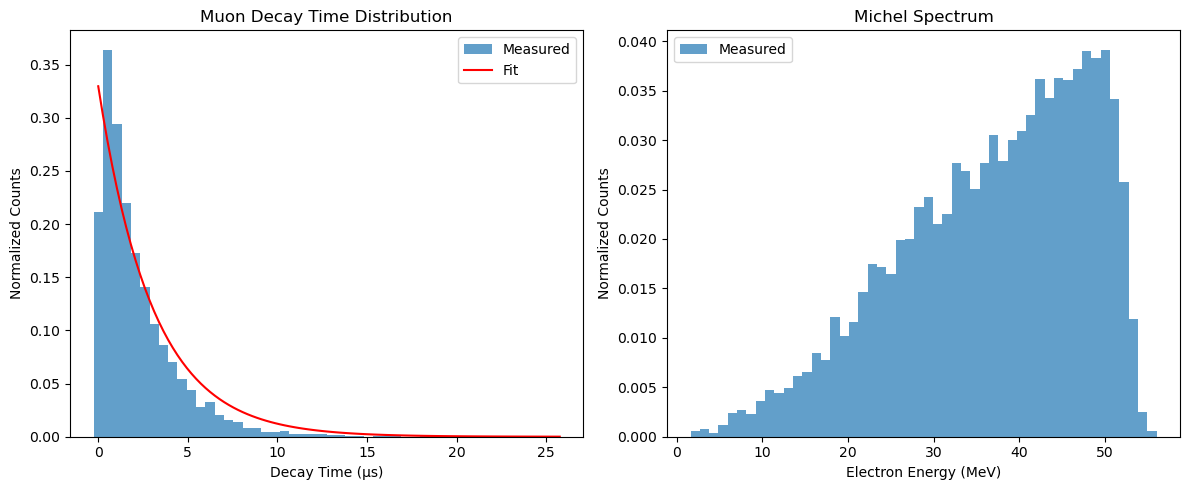

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import curve_fit

@dataclass
class DetectorConfig:
    """Configuration parameters for the detector"""
    energy_resolution: float  # Resolution in MeV
    time_resolution: float   # Resolution in ns
    efficiency: float        # Detection efficiency (0-1)
    acceptance_angle: float  # Maximum detection angle in radians

class MuonDecaySimulator:
    def __init__(self, n_events: int, detector_config: DetectorConfig):
        """
        Initialize the muon decay simulator
        
        Parameters:
        -----------
        n_events: int
            Number of decay events to simulate
        detector_config: DetectorConfig
            Detector configuration parameters
        """
        self.n_events = n_events
        self.detector = detector_config
        
        # Physical constants
        self.muon_lifetime = 2.197  # microseconds
        self.muon_mass = 105.66  # MeV
        self.electron_mass = 0.511  # MeV
    
    @staticmethod
    def exp_decay(t, tau):
        """Exponential decay function"""
        return np.exp(-t/tau) / tau
        
    def generate_decay_times(self):
        """Generate exponentially distributed decay times"""
        return np.random.exponential(self.muon_lifetime, self.n_events)
    
    def michel_spectrum(self):
        """
        Generate electron energies following Michel spectrum
        Simplified version - you might want to implement full spectrum
        """
        # Maximum electron energy
        E_max = self.muon_mass/2  # Neglecting electron mass for simplicity
        
        # Generate random energies with acceptance-rejection method
        energies = []
        while len(energies) < self.n_events:
            E = np.random.uniform(0, E_max)
            x = E/E_max
            prob = x**2 * (3 - 2*x)  # Simplified Michel spectrum
            if np.random.random() < prob:
                energies.append(E)
                
        return np.array(energies)
    
    def apply_detector_effects(self, true_times, true_energies):
        """Apply detector resolution and efficiency effects"""
        # Add gaussian smearing to times and energies
        measured_times = np.random.normal(true_times, self.detector.time_resolution)
        measured_energies = np.random.normal(true_energies, self.detector.energy_resolution)
        
        # Apply detection efficiency
        detected = np.random.random(self.n_events) < self.detector.efficiency
        
        return measured_times[detected], measured_energies[detected]
    
    def run_simulation(self):
        """Run the full simulation"""
        # Generate true values
        decay_times = self.generate_decay_times()
        electron_energies = self.michel_spectrum()
        
        # Apply detector effects
        measured_times, measured_energies = self.apply_detector_effects(
            decay_times, electron_energies
        )
        
        return {
            'true_times': decay_times,
            'true_energies': electron_energies,
            'measured_times': measured_times,
            'measured_energies': measured_energies
        }
    
    def analyze_results(self, results):
        """Perform basic analysis of the simulation results"""
        # Fit exponential to measured times
        measured_times = results['measured_times']
        hist, bins = np.histogram(measured_times, bins=50, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Exponential fit
        popt, pcov = curve_fit(self.exp_decay, bin_centers, hist)
        fitted_lifetime = popt[0]
        lifetime_uncertainty = np.sqrt(pcov[0,0])
        
        return {
            'fitted_lifetime': fitted_lifetime,
            'lifetime_uncertainty': lifetime_uncertainty
        }
    
    def plot_results(self, results, analysis):
        """Create plots of the simulation results"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot decay time distribution
        ax1.hist(results['measured_times'], bins=50, density=True, 
                alpha=0.7, label='Measured')
        t_plot = np.linspace(0, max(results['measured_times']), 100)
        ax1.plot(t_plot, self.exp_decay(t_plot, analysis['fitted_lifetime']), 
                'r-', label='Fit')
        ax1.set_xlabel('Decay Time (μs)')
        ax1.set_ylabel('Normalized Counts')
        ax1.set_title('Muon Decay Time Distribution')
        ax1.legend()
        
        # Plot energy spectrum
        ax2.hist(results['measured_energies'], bins=50, density=True,
                alpha=0.7, label='Measured')
        ax2.set_xlabel('Electron Energy (MeV)')
        ax2.set_ylabel('Normalized Counts')
        ax2.set_title('Michel Spectrum')
        ax2.legend()
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Configure detector
    detector_config = DetectorConfig(
        energy_resolution=1.0,  # 1 MeV resolution
        time_resolution=0.1,    # 0.1 μs resolution
        efficiency=0.8,         # 80% detection efficiency
        acceptance_angle=np.pi/2 # Accept particles in forward hemisphere
    )
    
    # Create and run simulation
    simulator = MuonDecaySimulator(n_events=10000, detector_config=detector_config)
    results = simulator.run_simulation()
    analysis = simulator.analyze_results(results)
    
    # Print results
    print(f"Fitted lifetime: {analysis['fitted_lifetime']:.3f} ± "
          f"{analysis['lifetime_uncertainty']:.3f} μs")
    
    # Create plots
    simulator.plot_results(results, analysis)
    plt.show()

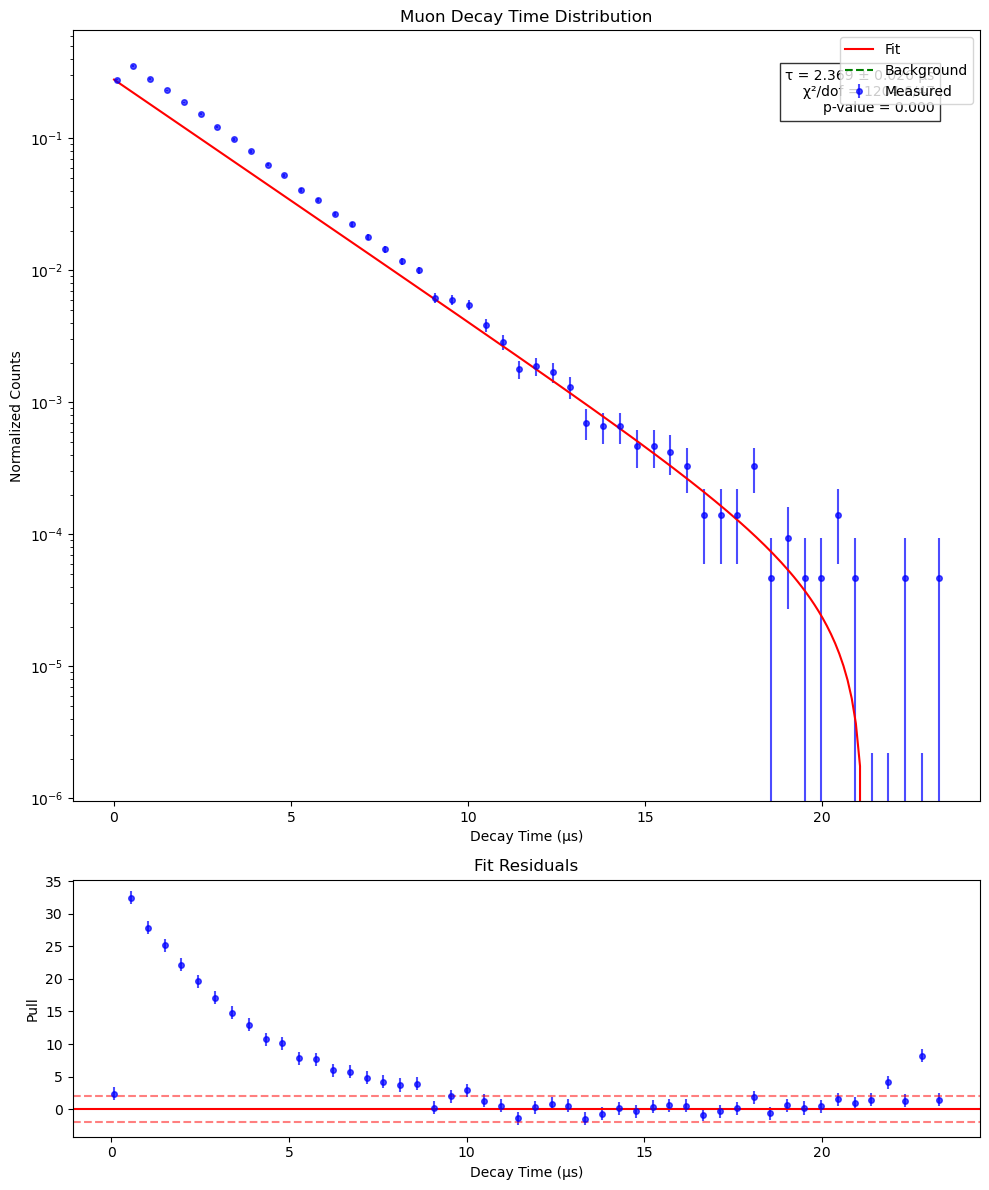

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import curve_fit
from scipy import stats

@dataclass
class DetectorConfig:
    """Configuration parameters for the detector"""
    energy_resolution: float  # Resolution in MeV
    time_resolution: float   # Resolution in ns
    efficiency: float        # Detection efficiency (0-1)
    acceptance_angle: float  # Maximum detection angle in radians
    background_rate: float   # Background rate in Hz
    systematic_uncertainty: float  # Systematic uncertainty in lifetime measurement (%)

class MuonDecaySimulator:
    def __init__(self, n_events: int, detector_config: DetectorConfig):
        self.n_events = n_events
        self.detector = detector_config
        
        # Physical constants
        self.muon_lifetime = 2.197  # microseconds
        self.muon_mass = 105.66  # MeV
        self.electron_mass = 0.511  # MeV
    
    @staticmethod
    def exp_decay(t, N0, tau, B):
        """
        Exponential decay function with background
        
        Parameters:
        -----------
        t : array-like
            Time values
        N0 : float
            Initial amplitude
        tau : float
            Lifetime
        B : float
            Background level
        """
        return N0 * np.exp(-t/tau) + B
        
    def generate_decay_times(self):
        """Generate exponentially distributed decay times"""
        signal_times = np.random.exponential(self.muon_lifetime, self.n_events)
        
        # Generate background events
        bg_window = max(signal_times) - min(signal_times)
        n_bg = int(self.detector.background_rate * bg_window)
        bg_times = np.random.uniform(0, bg_window, n_bg)
        
        # Combine signal and background
        all_times = np.concatenate([signal_times, bg_times])
        all_times.sort()  # Sort times in ascending order
        
        return all_times, len(signal_times)
    
    def apply_detector_effects(self, true_times):
        """Apply detector resolution and efficiency effects"""
        # Add gaussian smearing to times
        measured_times = np.random.normal(true_times, self.detector.time_resolution)
        
        # Apply detection efficiency
        detected = np.random.random(len(true_times)) < self.detector.efficiency
        
        return measured_times[detected]
    
    def run_simulation(self):
        """Run the full simulation"""
        # Generate true values
        decay_times, n_signal = self.generate_decay_times()
        
        # Apply detector effects
        measured_times = self.apply_detector_effects(decay_times)
        
        return {
            'measured_times': measured_times,
            'n_signal': n_signal
        }
    
    def analyze_results(self, results):
        """Perform detailed analysis of the lifetime measurement"""
        measured_times = results['measured_times']
        
        # Create histogram with error bars
        hist, bins = np.histogram(measured_times, bins=50)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_widths = bins[1:] - bins[:-1]
        
        # Calculate error bars (including background uncertainty)
        yerr = np.sqrt(hist + (self.detector.background_rate * bin_widths)**2)
        
        # Normalize histogram
        total_counts = np.sum(hist)
        hist_norm = hist / (total_counts * bin_widths)
        yerr_norm = yerr / (total_counts * bin_widths)
        
        # Fit with background
        try:
            popt, pcov = curve_fit(self.exp_decay, bin_centers, hist_norm, 
                                 p0=[np.max(hist_norm), self.muon_lifetime, 
                                    self.detector.background_rate/total_counts],
                                 sigma=yerr_norm,
                                 absolute_sigma=True)
        except RuntimeError:
            print("Warning: Fit did not converge")
            return None
            
        # Calculate goodness of fit
        residuals = hist_norm - self.exp_decay(bin_centers, *popt)
        chi_square = np.sum((residuals/yerr_norm)**2)
        dof = len(bin_centers) - len(popt)
        p_value = 1 - stats.chi2.cdf(chi_square, dof)
        
        # Calculate total uncertainty (statistical + systematic)
        stat_uncertainty = np.sqrt(pcov[1,1])
        sys_uncertainty = popt[1] * self.detector.systematic_uncertainty/100
        total_uncertainty = np.sqrt(stat_uncertainty**2 + sys_uncertainty**2)
        
        return {
            'fitted_lifetime': popt[1],
            'lifetime_uncertainty': total_uncertainty,
            'background_level': popt[2],
            'chi_square': chi_square,
            'dof': dof,
            'p_value': p_value,
            'hist_data': {
                'counts': hist_norm,
                'bins': bin_centers,
                'yerr': yerr_norm
            }
        }
    
    def plot_results(self, results, analysis):
        """Create detailed plots of the lifetime measurement"""
        if analysis is None:
            return None
            
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), 
                                      gridspec_kw={'height_ratios': [3, 1]})
        
        # Get histogram data
        hist_data = analysis['hist_data']
        
        # Plot decay time distribution with error bars
        ax1.errorbar(hist_data['bins'], hist_data['counts'], 
                    yerr=hist_data['yerr'], fmt='o', markersize=4,
                    label='Measured', color='blue', alpha=0.7)
        
        # Plot fit
        t_plot = np.linspace(0, max(hist_data['bins']), 200)
        fit = self.exp_decay(t_plot, 
                           analysis['hist_data']['counts'][0],
                           analysis['fitted_lifetime'],
                           analysis['background_level'])
        ax1.plot(t_plot, fit, 'r-', label='Fit')
        
        # Plot background level
        ax1.axhline(y=analysis['background_level'], color='g', 
                   linestyle='--', label='Background')
        
        # Add fit information to plot
        fit_info = (
            f"τ = {analysis['fitted_lifetime']:.3f} ± {analysis['lifetime_uncertainty']:.3f} μs\n"
            f"χ²/dof = {analysis['chi_square']:.1f}/{analysis['dof']}\n"
            f"p-value = {analysis['p_value']:.3f}"
        )
        ax1.text(0.95, 0.95, fit_info, transform=ax1.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.8))
        
        ax1.set_xlabel('Decay Time (μs)')
        ax1.set_ylabel('Normalized Counts')
        ax1.set_title('Muon Decay Time Distribution')
        ax1.legend()
        ax1.set_yscale('log')
        
        # Plot residuals
        residuals = (hist_data['counts'] - 
                    self.exp_decay(hist_data['bins'], 
                                 hist_data['counts'][0],
                                 analysis['fitted_lifetime'],
                                 analysis['background_level'])) / hist_data['yerr']
        ax2.errorbar(hist_data['bins'], residuals, yerr=1, fmt='o',
                    markersize=4, color='blue', alpha=0.7)
        ax2.axhline(y=0, color='r', linestyle='-')
        ax2.axhline(y=2, color='r', linestyle='--', alpha=0.5)
        ax2.axhline(y=-2, color='r', linestyle='--', alpha=0.5)
        
        ax2.set_xlabel('Decay Time (μs)')
        ax2.set_ylabel('Pull')
        ax2.set_title('Fit Residuals')
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Configure detector with more realistic parameters
    detector_config = DetectorConfig(
        energy_resolution=1.0,     # 1 MeV resolution
        time_resolution=0.05,      # 50 ns resolution
        efficiency=0.9,            # 90% detection efficiency
        acceptance_angle=np.pi/2,  # Accept particles in forward hemisphere
        background_rate=0.1,       # 0.1 Hz background rate
        systematic_uncertainty=1.0  # 1% systematic uncertainty
    )
    
    # Create and run simulation
    simulator = MuonDecaySimulator(n_events=50000, detector_config=detector_config)
    results = simulator.run_simulation()
    analysis = simulator.analyze_results(results)
    
    # Create plots
    fig = simulator.plot_results(results, analysis)
    plt.show()

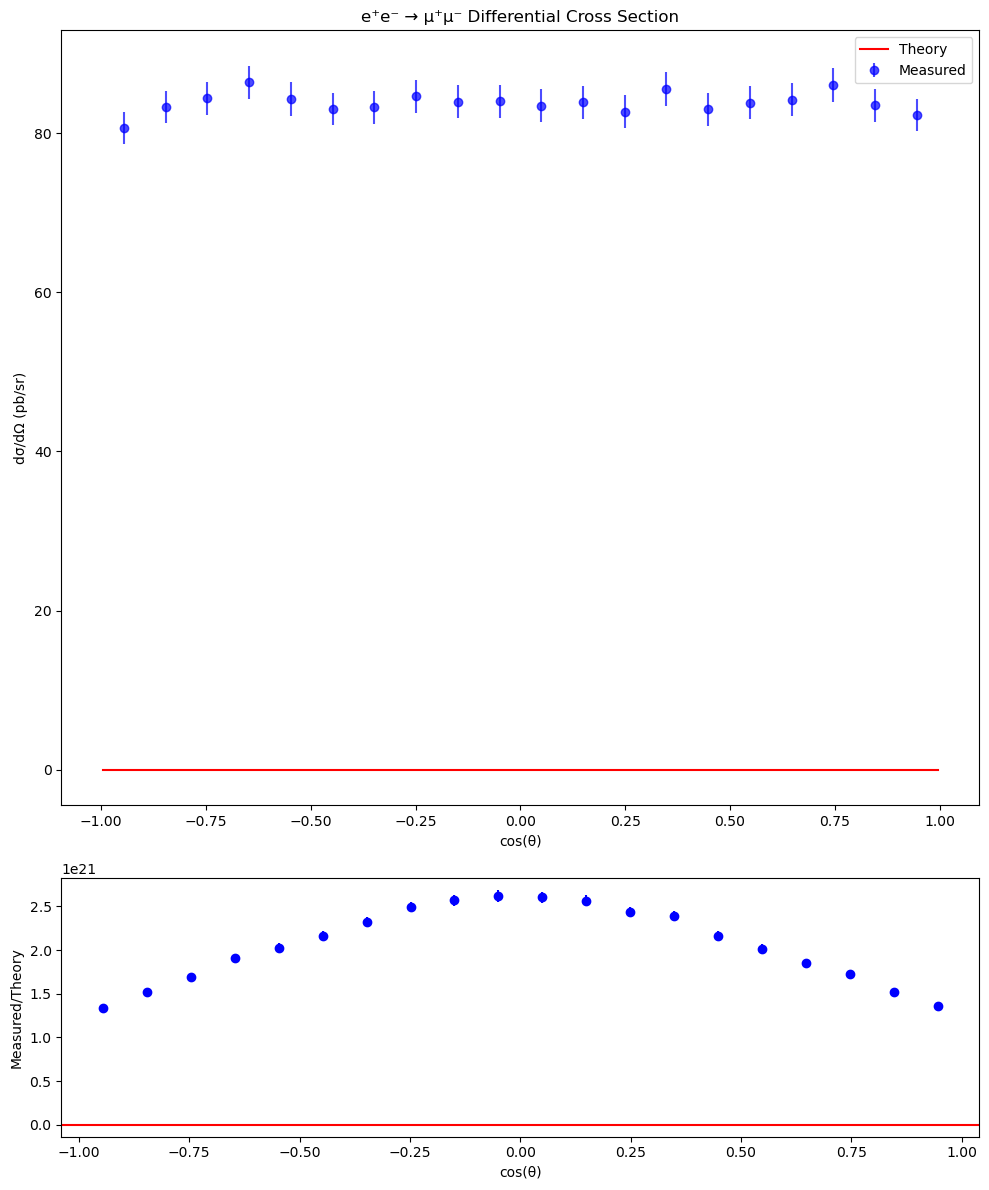

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.constants import c, hbar, e, m_e, alpha
from scipy.stats import norm
from scipy.optimize import curve_fit

@dataclass
class DetectorConfig:
    """Configuration for detector parameters"""
    angular_resolution: float    # Angular resolution in radians
    energy_resolution: float     # Energy resolution (ΔE/E)
    acceptance_min_angle: float  # Minimum acceptance angle
    acceptance_max_angle: float  # Maximum acceptance angle
    efficiency: float           # Detection efficiency
    luminosity: float           # Integrated luminosity (pb^-1)
    background_rate: float      # Background rate per angle bin

class CrossSectionSimulator:
    def __init__(self, beam_energy: float, detector_config: DetectorConfig):
        """
        Initialize cross section simulator
        
        Parameters:
        -----------
        beam_energy: float
            Beam energy in GeV
        detector_config: DetectorConfig
            Detector configuration parameters
        """
        self.beam_energy = beam_energy
        self.detector = detector_config
        self.s = 4 * beam_energy**2  # Center of mass energy squared
        
    def differential_cross_section(self, cos_theta):
        """
        Calculate differential cross section for e⁺e⁻ → μ⁺μ⁻
        
        Parameters:
        -----------
        cos_theta: array-like
            Cosine of scattering angle
        
        Returns:
        --------
        dsigma/dΩ in pb/sr
        """
        # QED formula for e⁺e⁻ → μ⁺μ⁻
        alpha_em = 1/137.036
        prefactor = alpha_em**2 * hbar**2 * c**2 / (2 * self.s)
        return prefactor * (1 + cos_theta**2) * 1e40  # Convert to pb
    
    def generate_events(self, n_events: int):
        """Generate Monte Carlo events"""
        # Generate cos(theta) with acceptance cuts
        min_cos = np.cos(self.detector.acceptance_max_angle)
        max_cos = np.cos(self.detector.acceptance_min_angle)
        
        # Use acceptance-rejection method for proper angular distribution
        cos_theta = []
        while len(cos_theta) < n_events:
            cos_t = np.random.uniform(min_cos, max_cos)
            if np.random.random() < (1 + cos_t**2):
                cos_theta.append(cos_t)
        cos_theta = np.array(cos_theta)
        
        # Generate phi uniformly
        phi = np.random.uniform(0, 2*np.pi, n_events)
        
        # Calculate true energies (beam energy in CM frame)
        energies = np.full_like(cos_theta, self.beam_energy)
        
        return {
            'cos_theta': cos_theta,
            'phi': phi,
            'energy': energies
        }
    
    def apply_detector_effects(self, true_events):
        """Apply detector resolution and efficiency"""
        # Apply angular smearing
        cos_theta = true_events['cos_theta'] + np.random.normal(
            0, self.detector.angular_resolution, len(true_events['cos_theta']))
        
        # Apply energy resolution
        energies = true_events['energy'] * np.random.normal(
            1, self.detector.energy_resolution, len(true_events['energy']))
        
        # Apply efficiency
        detected = np.random.random(len(cos_theta)) < self.detector.efficiency
        
        return {
            'cos_theta': cos_theta[detected],
            'energy': energies[detected],
            'phi': true_events['phi'][detected]
        }
    
    def add_background(self, events):
        """Add background events"""
        n_signal = len(events['cos_theta'])
        n_background = int(self.detector.background_rate * n_signal)
        
        # Generate uniform background
        bg_cos_theta = np.random.uniform(
            np.cos(self.detector.acceptance_max_angle),
            np.cos(self.detector.acceptance_min_angle),
            n_background
        )
        bg_energy = np.random.uniform(
            0.8 * self.beam_energy,
            1.2 * self.beam_energy,
            n_background
        )
        bg_phi = np.random.uniform(0, 2*np.pi, n_background)
        
        # Combine signal and background
        events['cos_theta'] = np.concatenate([events['cos_theta'], bg_cos_theta])
        events['energy'] = np.concatenate([events['energy'], bg_energy])
        events['phi'] = np.concatenate([events['phi'], bg_phi])
        
        return events
    
    def analyze_cross_section(self, events, n_bins=20):
        """Calculate measured differential cross section"""
        # Create histogram of cos(theta)
        hist, bin_edges = np.histogram(
            events['cos_theta'], 
            bins=n_bins,
            range=(np.cos(self.detector.acceptance_max_angle),
                  np.cos(self.detector.acceptance_min_angle))
        )
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        bin_widths = bin_edges[1:] - bin_edges[:-1]
        
        # Calculate differential cross section
        # σ = N / (L * ε * ΔΩ)
        delta_omega = 2*np.pi * bin_widths  # ΔΩ = 2π * Δ(cos θ)
        cross_section = hist / (self.detector.luminosity * 
                              self.detector.efficiency * 
                              delta_omega)
        
        # Calculate errors (statistical + systematic)
        statistical_error = np.sqrt(hist) / (self.detector.luminosity * 
                                           self.detector.efficiency * 
                                           delta_omega)
        systematic_error = 0.02 * cross_section  # Assume 2% systematic
        total_error = np.sqrt(statistical_error**2 + systematic_error**2)
        
        return {
            'cos_theta': bin_centers,
            'cross_section': cross_section,
            'error': total_error
        }
    
    def plot_results(self, measured, n_points=1000):
        """Plot measured cross section with theory curve"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12),
                                      gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot measured points
        ax1.errorbar(measured['cos_theta'], measured['cross_section'],
                    yerr=measured['error'], fmt='o', label='Measured',
                    color='blue', alpha=0.7)
        
        # Plot theory curve
        cos_theta_theory = np.linspace(
            np.cos(self.detector.acceptance_max_angle),
            np.cos(self.detector.acceptance_min_angle),
            n_points
        )
        theory = self.differential_cross_section(cos_theta_theory)
        ax1.plot(cos_theta_theory, theory, 'r-', label='Theory')
        
        ax1.set_xlabel('cos(θ)')
        ax1.set_ylabel('dσ/dΩ (pb/sr)')
        ax1.set_title('e⁺e⁻ → μ⁺μ⁻ Differential Cross Section')
        ax1.legend()
        
        # Plot ratio
        interp_theory = np.interp(measured['cos_theta'], 
                                cos_theta_theory, theory)
        ratio = measured['cross_section'] / interp_theory
        ratio_error = measured['error'] / interp_theory
        
        ax2.errorbar(measured['cos_theta'], ratio,
                    yerr=ratio_error, fmt='o', color='blue')
        ax2.axhline(y=1, color='r', linestyle='-')
        ax2.set_xlabel('cos(θ)')
        ax2.set_ylabel('Measured/Theory')
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Configure detector
    detector_config = DetectorConfig(
        angular_resolution=0.01,    # 10 mrad
        energy_resolution=0.02,     # 2%
        acceptance_min_angle=0.1,   # rad
        acceptance_max_angle=np.pi-0.1,
        efficiency=0.9,
        luminosity=100,            # pb^-1
        background_rate=0.05       # 5% background
    )
    
    # Create simulator
    simulator = CrossSectionSimulator(beam_energy=45.6, # LEP energy
                                    detector_config=detector_config)
    
    # Generate and process events
    true_events = simulator.generate_events(n_events=100000)
    detected_events = simulator.apply_detector_effects(true_events)
    final_events = simulator.add_background(detected_events)
    
    # Analyze and plot
    measured = simulator.analyze_cross_section(final_events)
    simulator.plot_results(measured)
    plt.show()


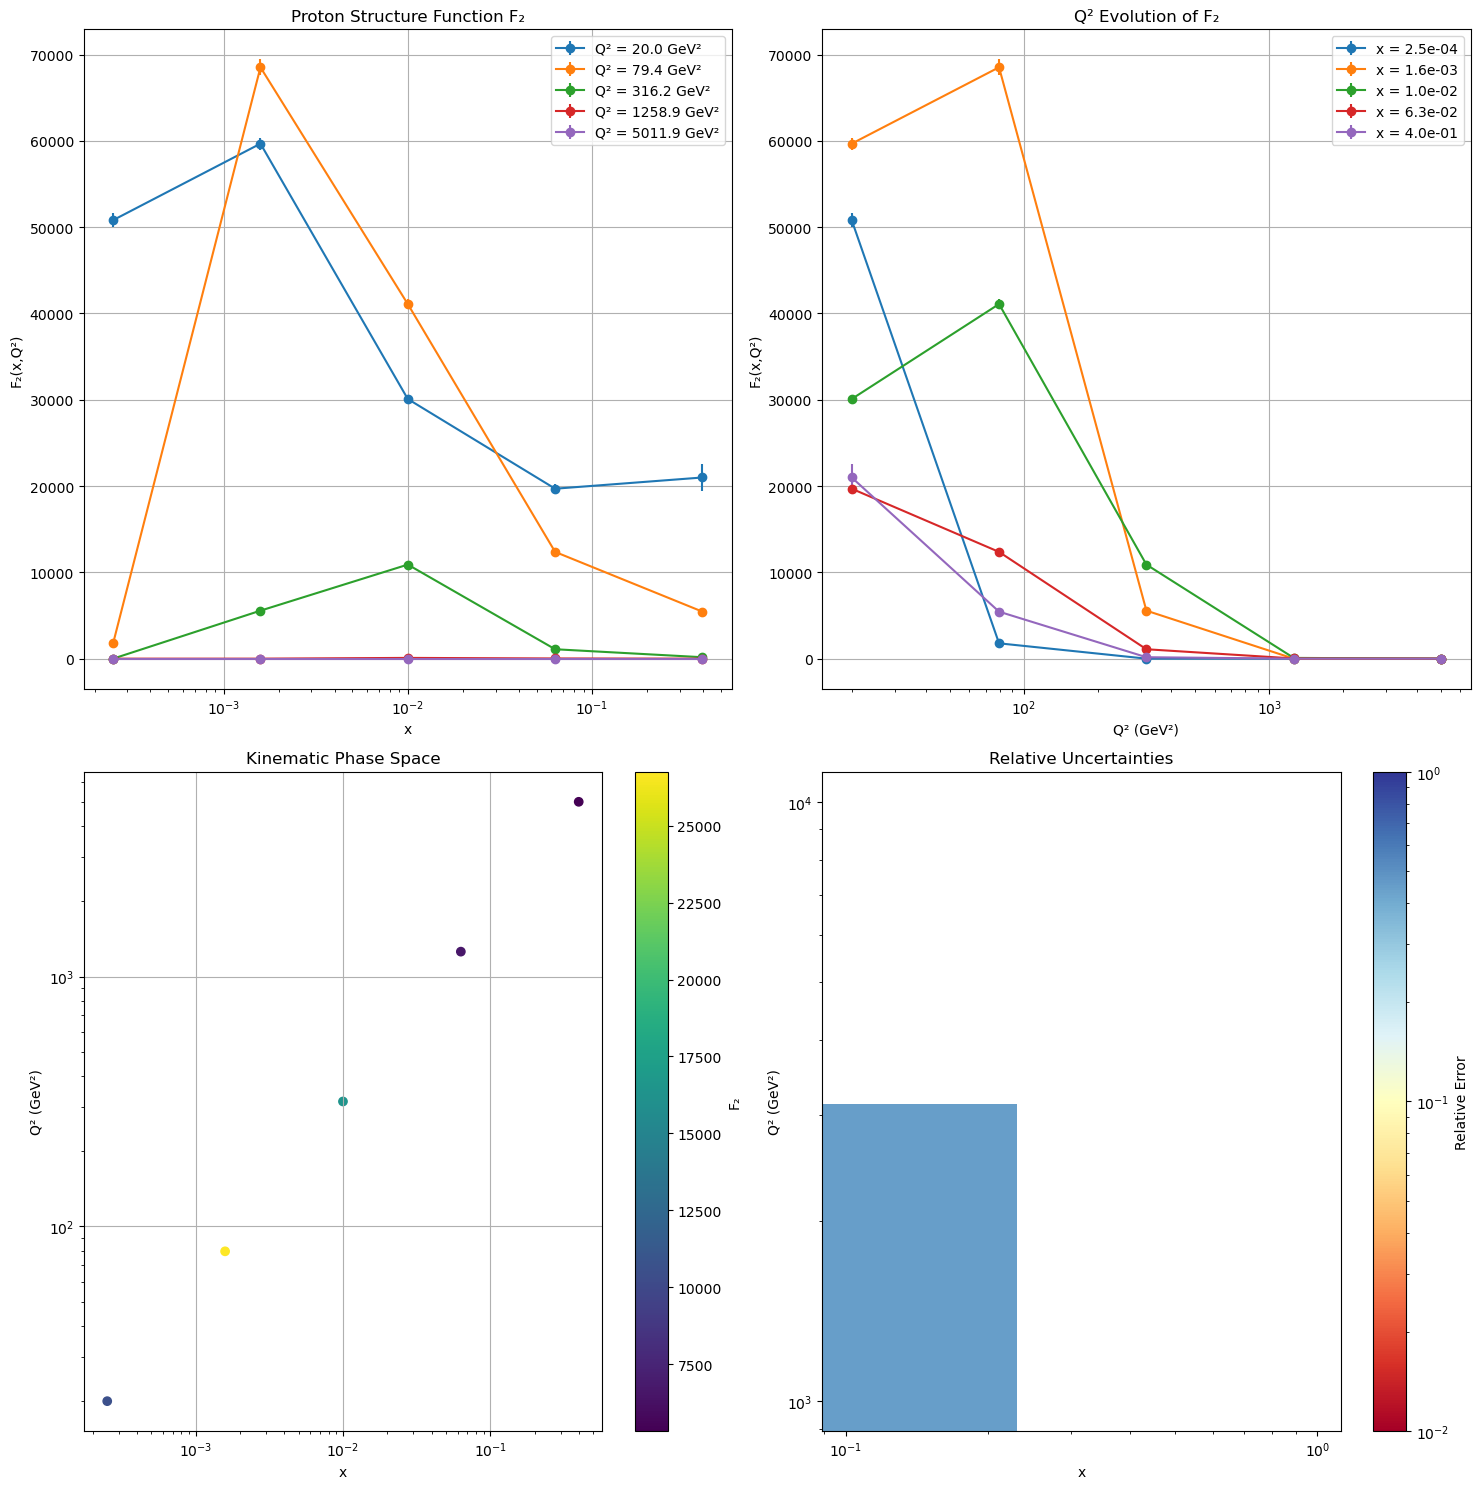

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator
from dataclasses import dataclass
from scipy.constants import c, hbar, e, m_e, m_p
import warnings
warnings.filterwarnings('ignore')

@dataclass
class DetectorConfig:
    """Configuration for DIS detector parameters"""
    e_resolution_a: float
    e_resolution_b: float
    theta_resolution: float
    min_theta: float
    max_theta: float
    min_energy: float
    tracking_efficiency: float
    calorimeter_efficiency: float
    luminosity: float
    
    def energy_resolution(self, energy):
        """Calculate energy resolution at given energy (GeV)"""
        return np.sqrt((self.e_resolution_a/np.sqrt(energy))**2 + 
                      self.e_resolution_b**2)

class DISSimulator:
    def __init__(self, beam_energy: float, detector_config: DetectorConfig):
        self.beam_energy = beam_energy
        self.detector = detector_config
        self.proton_mass = 0.938  # GeV
        self.proton_energy = 920  # GeV (HERA-like)
        self.s = 4 * beam_energy * self.proton_energy
        self._initialize_structure_functions()
    
    def _initialize_structure_functions(self):
        """Initialize simple parametrization of structure functions"""
        self.x_grid = np.logspace(-4, 0, 100)
        self.Q2_grid = np.logspace(0, 5, 100)
        X, Q2 = np.meshgrid(self.x_grid, self.Q2_grid)
        
        # Simple parametrization of F2(x,Q2)
        self.F2 = 0.3 * (1-X)**4 * np.log(Q2/0.25) * (X**(-0.2))
        
        self.F2_interp = RegularGridInterpolator(
            (self.Q2_grid, self.x_grid),
            self.F2,
            method='linear',
            bounds_error=False,
            fill_value=None
        )
    
    def get_F2(self, x, Q2):
        """Get F2 structure function at given x, Q2"""
        points = np.column_stack((Q2, x))
        return self.F2_interp(points)
    
    def generate_events(self, n_events: int):
        """
        Generate DIS events using acceptance-rejection method
        """
        events = {
            'x': [],
            'Q2': [],
            'y': [],
            'E_scattered': [],
            'theta': [],
            'weight': []
        }
        
        n_accepted = 0
        max_tries = n_events * 100  # Avoid infinite loop
        n_tries = 0
        
        while n_accepted < n_events and n_tries < max_tries:
            # Generate log-uniform in x and Q2
            log_x = np.random.uniform(np.log(1e-4), np.log(1.0))
            log_Q2 = np.random.uniform(np.log(1.0), np.log(1e4))
            
            x = np.exp(log_x)
            Q2 = np.exp(log_Q2)
            y = Q2 / (self.s * x)
            
            if y > 1 or y < 0:
                n_tries += 1
                continue
            
            # Calculate scattered electron energy and angle
            E_scattered = self.beam_energy * (1 - y)
            cos_theta = 1 - Q2/(2 * self.beam_energy * E_scattered)
            
            if abs(cos_theta) > 1:
                n_tries += 1
                continue
            
            theta = np.arccos(cos_theta)
            
            # Check detector acceptance
            if (theta < self.detector.min_theta or 
                theta > self.detector.max_theta or
                E_scattered < self.detector.min_energy):
                n_tries += 1
                continue
            
            # Get structure function and cross section
            F2 = self.get_F2(x, Q2)
            
            # Simple cross section formula
            alpha = 1/137.036
            prefactor = 2 * np.pi * alpha**2 / (x * Q2**2)
            sigma_r = F2 * (1 - y + y**2/2)
            xsec = prefactor * sigma_r
            
            # Accept/reject
            if np.random.random() < xsec/1e-5:  # Normalized to typical maximum
                events['x'].append(x)
                events['Q2'].append(Q2)
                events['y'].append(y)
                events['E_scattered'].append(E_scattered)
                events['theta'].append(theta)
                events['weight'].append(xsec)
                n_accepted += 1
            
            n_tries += 1
        
        if n_accepted < n_events:
            print(f"Warning: Only generated {n_accepted} events out of {n_events} requested")
        
        # Convert to arrays
        for key in events:
            events[key] = np.array(events[key])
        
        return events
    
    def apply_detector_effects(self, true_events):
        """Apply detector resolution and efficiency effects"""
        n_events = len(true_events['x'])
        
        # Apply energy resolution
        E_resolution = self.detector.energy_resolution(true_events['E_scattered'])
        E_measured = np.random.normal(true_events['E_scattered'],
                                    E_resolution * true_events['E_scattered'])
        
        # Apply angular resolution
        theta_measured = np.random.normal(true_events['theta'],
                                        self.detector.theta_resolution)
        
        # Apply efficiency
        detected = (np.random.random(n_events) < 
                   self.detector.tracking_efficiency * 
                   self.detector.calorimeter_efficiency)
        
        # Recalculate kinematics
        Q2_measured = 2 * self.beam_energy * E_measured * (1 - np.cos(theta_measured))
        y_measured = 1 - E_measured/self.beam_energy
        x_measured = Q2_measured / (self.s * y_measured)
        
        measured_events = {
            'x': x_measured[detected],
            'Q2': Q2_measured[detected],
            'y': y_measured[detected],
            'E_scattered': E_measured[detected],
            'theta': theta_measured[detected],
            'weight': true_events['weight'][detected]
        }
        
        return measured_events
    
    def analyze_events(self, events, n_bins_x=5, n_bins_Q2=5):
        """Analyze events to extract F2 structure function"""
        # Create bins in log(x) and log(Q2)
        x_bins = np.logspace(-4, 0, n_bins_x + 1)
        Q2_bins = np.logspace(1, 4, n_bins_Q2 + 1)
        
        # Arrays to store results
        x_centers = np.sqrt(x_bins[1:] * x_bins[:-1])
        Q2_centers = np.sqrt(Q2_bins[1:] * Q2_bins[:-1])
        F2_measured = np.zeros((n_bins_x, n_bins_Q2))
        F2_errors = np.zeros((n_bins_x, n_bins_Q2))
        
        for i in range(n_bins_x):
            for j in range(n_bins_Q2):
                # Select events in this bin
                mask = ((events['x'] >= x_bins[i]) & 
                       (events['x'] < x_bins[i+1]) &
                       (events['Q2'] >= Q2_bins[j]) &
                       (events['Q2'] < Q2_bins[j+1]))
                
                if np.sum(mask) > 0:
                    bin_events = {k: v[mask] for k, v in events.items()}
                    
                    # Calculate average kinematics in bin
                    x_avg = np.mean(bin_events['x'])
                    Q2_avg = np.mean(bin_events['Q2'])
                    y_avg = np.mean(bin_events['y'])
                    
                    # Extract F2 from cross section
                    sigma = np.sum(bin_events['weight'])
                    N = len(bin_events['x'])
                    
                    # Calculate F2 from cross section
                    alpha = 1/137.036
                    prefactor = 2 * np.pi * alpha**2 / (x_avg * Q2_avg**2)
                    sigma_r = sigma / prefactor
                    F2_measured[i,j] = sigma_r / (1 - y_avg + y_avg**2/2)
                    
                    # Statistical error
                    F2_errors[i,j] = F2_measured[i,j] / np.sqrt(N) if N > 0 else 0
        
        return {
            'x_bins': x_centers,
            'Q2_bins': Q2_centers,
            'F2': F2_measured,
            'F2_error': F2_errors
        }
    
    def plot_results(self, analysis_results):
        """Plot measured F2 structure function"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        axes = axes.flatten()
        
        x_bins = analysis_results['x_bins']
        Q2_bins = analysis_results['Q2_bins']
        F2 = analysis_results['F2']
        F2_error = analysis_results['F2_error']
        
        # Plot F2 vs x for different Q2 bins
        for i, Q2 in enumerate(Q2_bins):
            ax = axes[0]
            ax.errorbar(x_bins, F2[:,i], yerr=F2_error[:,i],
                       label=f'Q² = {Q2:.1f} GeV²',
                       marker='o')
        
        ax.set_xscale('log')
        ax.set_xlabel('x')
        ax.set_ylabel('F₂(x,Q²)')
        ax.set_title('Proton Structure Function F₂')
        ax.legend()
        ax.grid(True)
        
        # Plot F2 vs Q2 for different x bins
        for i, x in enumerate(x_bins):
            ax = axes[1]
            ax.errorbar(Q2_bins, F2[i,:], yerr=F2_error[i,:],
                       label=f'x = {x:.1e}',
                       marker='o')
        
        ax.set_xscale('log')
        ax.set_xlabel('Q² (GeV²)')
        ax.set_ylabel('F₂(x,Q²)')
        ax.set_title('Q² Evolution of F₂')
        ax.legend()
        ax.grid(True)
        
        # Plot phase space
        ax = axes[2]
        scatter = ax.scatter(analysis_results['x_bins'],
                           analysis_results['Q2_bins'],
                           c=np.mean(analysis_results['F2'], axis=1),
                           cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='F₂')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('x')
        ax.set_ylabel('Q² (GeV²)')
        ax.set_title('Kinematic Phase Space')
        ax.grid(True)
        
        # Plot relative errors
        ax = axes[3]
        rel_error = np.where(analysis_results['F2'] > 0,
                            analysis_results['F2_error'] / analysis_results['F2'],
                            0)
        im = ax.pcolormesh(x_bins, Q2_bins, rel_error.T,
                          cmap='RdYlBu', norm=LogNorm(vmin=0.01, vmax=1.0))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('x')
        ax.set_ylabel('Q² (GeV²)')
        ax.set_title('Relative Uncertainties')
        plt.colorbar(im, ax=ax, label='Relative Error')
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Configure detector (HERA-like parameters)
    detector_config = DetectorConfig(
        e_resolution_a=0.10,    # 10%/√E
        e_resolution_b=0.02,    # 2%
        theta_resolution=0.001,  # 1 mrad
        min_theta=0.1,          # rad
        max_theta=3.0,          # rad
        min_energy=1.0,         # GeV
        tracking_efficiency=0.95,
        calorimeter_efficiency=0.98,
        luminosity=100          # pb^-1
    )
    
    # Create simulator
    simulator = DISSimulator(beam_energy=27.6,  # HERA electron beam
                           detector_config=detector_config)
    
    # Generate and process events
    true_events = simulator.generate_events(n_events=50000)
    measured_events = simulator.apply_detector_effects(true_events)
    
    # Analyze and plot
    analysis = simulator.analyze_events(measured_events)
    simulator.plot_results(analysis)
    plt.show()

Generating events...
Generated 10 events

Plotting event displays...


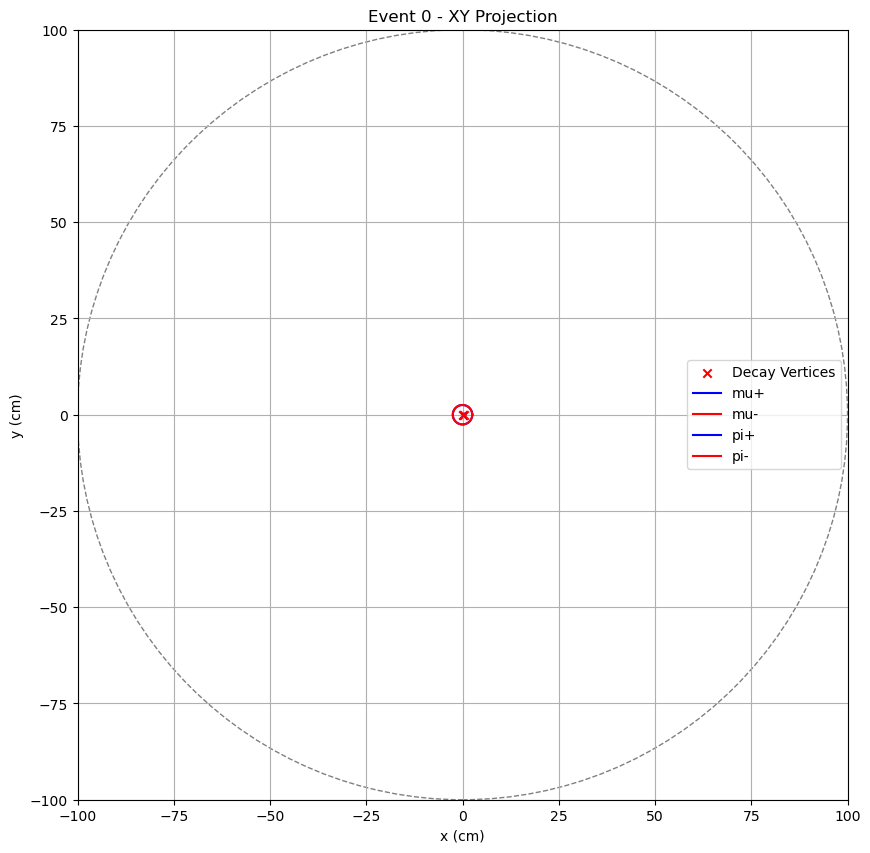

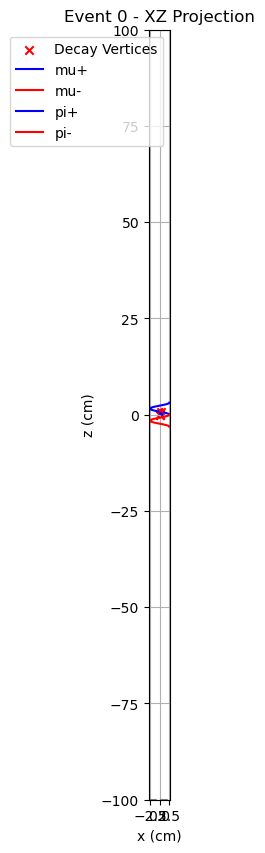

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Optional

@dataclass
class Particle:
    name: str
    mass: float
    lifetime: float
    charge: int
    momentum: np.ndarray
    position: np.ndarray

@dataclass
class DecayChannel:
    products: List[str]
    branching_ratio: float

class ParticleData:
    @staticmethod
    def get_particle_data():
        return {
            'B0': {
                'mass': 5.279,
                'lifetime': 1.519e-12,
                'charge': 0,
                'decay_channels': [
                    DecayChannel(['K-', 'pi+'], 0.2),
                    DecayChannel(['D-', 'pi+'], 0.3),
                    DecayChannel(['J/psi', 'K0'], 0.5)
                ]
            },
            'D-': {
                'mass': 1.870,
                'lifetime': 1.040e-12,
                'charge': -1,
                'decay_channels': [
                    DecayChannel(['K+', 'pi-', 'pi-'], 1.0)
                ]
            },
            'K0': {
                'mass': 0.498,
                'lifetime': 0.895e-10,
                'charge': 0,
                'decay_channels': [
                    DecayChannel(['pi+', 'pi-'], 1.0)
                ]
            },
            'J/psi': {
                'mass': 3.097,
                'lifetime': 7.2e-21,
                'charge': 0,
                'decay_channels': [
                    DecayChannel(['mu+', 'mu-'], 1.0)
                ]
            },
            'pi+': {'mass': 0.139, 'lifetime': float('inf'), 'charge': 1, 'decay_channels': []},
            'pi-': {'mass': 0.139, 'lifetime': float('inf'), 'charge': -1, 'decay_channels': []},
            'K+': {'mass': 0.494, 'lifetime': float('inf'), 'charge': 1, 'decay_channels': []},
            'K-': {'mass': 0.494, 'lifetime': float('inf'), 'charge': -1, 'decay_channels': []},
            'mu+': {'mass': 0.105, 'lifetime': float('inf'), 'charge': 1, 'decay_channels': []},
            'mu-': {'mass': 0.105, 'lifetime': float('inf'), 'charge': -1, 'decay_channels': []}
        }

class DecayChainSimulator:
    def __init__(self):
        self.particles = ParticleData.get_particle_data()
        self.detector = {
            'tracking_resolution': 0.001,  # 1 mm
            'momentum_resolution': 0.01,   # 1%
            'magnetic_field': 2.0,         # Tesla
            'radius': 100.0,               # cm
            'length': 200.0                # cm
        }

    def generate_decay_time(self, lifetime):
        """Generate exponential decay time"""
        return -lifetime * np.log(np.random.random())

    def _generate_phase_space(self, total_mass: float, masses: List[float]) -> List[np.ndarray]:
        """Generate phase space momenta for multi-body decay"""
        n = len(masses)
        
        if n == 2:
            m1, m2 = masses
            # Calculate momentum magnitude in CM frame
            p_cm = np.sqrt((total_mass**2 - (m1 + m2)**2) * 
                          (total_mass**2 - (m1 - m2)**2)) / (2 * total_mass)
            
            # Generate random direction
            phi = np.random.uniform(0, 2*np.pi)
            cos_theta = np.random.uniform(-1, 1)
            sin_theta = np.sqrt(1 - cos_theta**2)
            
            p1 = p_cm * np.array([sin_theta * np.cos(phi),
                                 sin_theta * np.sin(phi),
                                 cos_theta])
            return [p1, -p1]
        
        elif n == 3:
            m1, m2, m3 = masses
            total_m = sum(masses)
            
            if total_mass <= total_m:
                raise ValueError("Not enough energy for decay")
            
            E_total = total_mass
            
            for _ in range(1000):
                # Generate random energy fractions
                r1, r2 = np.random.random(2)
                E1 = m1 + (E_total - total_m) * r1
                E2 = m2 + (E_total - E1 - m3 - m2) * r2
                E3 = E_total - E1 - E2
                
                if E3 < m3:
                    continue
                
                # Calculate momenta magnitudes
                p1 = np.sqrt(max(0, E1**2 - m1**2))
                p2 = np.sqrt(max(0, E2**2 - m2**2))
                p3 = np.sqrt(max(0, E3**2 - m3**2))
                
                # Check triangle inequality
                if (p1 + p2 < p3) or (p2 + p3 < p1) or (p3 + p1 < p2):
                    continue
                
                # Generate random directions
                cos_theta1 = np.random.uniform(-1, 1)
                phi1 = np.random.uniform(0, 2*np.pi)
                cos_theta2 = np.random.uniform(-1, 1)
                phi2 = np.random.uniform(0, 2*np.pi)
                
                sin_theta1 = np.sqrt(1 - cos_theta1**2)
                sin_theta2 = np.sqrt(1 - cos_theta2**2)
                
                # Calculate momentum vectors
                p1_vec = p1 * np.array([
                    sin_theta1 * np.cos(phi1),
                    sin_theta1 * np.sin(phi1),
                    cos_theta1
                ])
                
                p2_vec = p2 * np.array([
                    sin_theta2 * np.cos(phi2),
                    sin_theta2 * np.sin(phi2),
                    cos_theta2
                ])
                
                p3_vec = -(p1_vec + p2_vec)
                
                # Check momentum conservation
                if np.abs(np.sqrt(np.sum(p3_vec**2)) - p3) < 0.01:
                    return [p1_vec, p2_vec, p3_vec]
            
            raise RuntimeError("Failed to generate valid phase space")
        
        else:
            raise ValueError(f"Phase space generation for {n}-body decay not implemented")

    def decay_particle(self, particle: Particle) -> List[Particle]:
        """Simulate particle decay"""
        props = self.particles[particle.name]
        
        if not props['decay_channels']:
            return []
        
        # Choose decay channel
        r = np.random.random()
        cumsum = 0
        chosen_channel = None
        for channel in props['decay_channels']:
            cumsum += channel.branching_ratio
            if r < cumsum:
                chosen_channel = channel
                break
                
        if chosen_channel is None:
            return []
        
        # Generate momenta
        daughter_masses = [self.particles[p]['mass'] for p in chosen_channel.products]
        
        try:
            momenta = self._generate_phase_space(props['mass'], daughter_masses)
        except (RuntimeError, ValueError) as e:
            print(f"Phase space generation failed for {particle.name}: {e}")
            return []
        
        # Create daughter particles
        products = []
        for name, p in zip(chosen_channel.products, momenta):
            daughter_props = self.particles[name]
            products.append(Particle(
                name=name,
                mass=daughter_props['mass'],
                lifetime=daughter_props['lifetime'],
                charge=daughter_props['charge'],
                momentum=p,
                position=particle.position.copy()
            ))
        
        return products

    def simulate_event(self, initial_particle: str) -> Dict:
        """Simulate a single decay chain event"""
        # Create initial particle
        props = self.particles[initial_particle]
        p0 = Particle(
            name=initial_particle,
            mass=props['mass'],
            lifetime=props['lifetime'],
            charge=props['charge'],
            momentum=np.array([0, 0, 5.0]),  # 5 GeV along z
            position=np.zeros(3)
        )
        
        event = {
            'particles': [p0],
            'vertices': [],
            'tracks': []
        }
        
        particles_to_decay = [p0]
        while particles_to_decay:
            particle = particles_to_decay.pop(0)
            
            if particle.lifetime < float('inf'):
                decay_time = self.generate_decay_time(particle.lifetime)
                beta = particle.momentum / np.sqrt(np.sum(particle.momentum**2) + particle.mass**2)
                decay_vertex = particle.position + beta * decay_time * 3e10
                
                products = self.decay_particle(particle)
                if products:
                    event['vertices'].append(decay_vertex)
                    event['particles'].extend(products)
                    
                    for product in products:
                        if product.lifetime == float('inf'):
                            track = self._simulate_track(product, decay_vertex)
                            if track is not None:
                                event['tracks'].append(track)
                        else:
                            product.position = decay_vertex
                            particles_to_decay.append(product)
        
        return event

    def _simulate_track(self, particle: Particle, vertex: np.ndarray) -> Optional[Dict]:
        """Simulate particle track through detector"""
        p = np.sqrt(np.sum(particle.momentum**2))
        pt = np.sqrt(particle.momentum[0]**2 + particle.momentum[1]**2)
        
        if pt < 0.1:  # Minimum pT cut
            return None
        
        # Calculate helix parameters
        r = pt / (0.3 * self.detector['magnetic_field'])
        
        # Generate points along trajectory
        t = np.linspace(0, 2*np.pi, 100)
        x = vertex[0] + r * np.cos(t)
        y = vertex[1] + r * np.sin(t)
        z = vertex[2] + t * particle.momentum[2]/p * r
        
        points = np.column_stack([x, y, z])
        points += np.random.normal(0, self.detector['tracking_resolution'], points.shape)
        
        return {'particle': particle, 'points': points}

    def simulate_chain(self, initial_particle: str, n_events: int = 1000) -> List[Dict]:
        """Simulate multiple decay chain events"""
        events = []
        for i in range(n_events):
            events.append(self.simulate_event(initial_particle))
            if (i + 1) % 10 == 0:
                print(f"Generated {i + 1} events")
        return events

    def plot_event(self, event: Dict, projection: str = 'xy'):
        """Plot decay chain event display"""
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot detector outline
        if projection == 'xy':
            circle = plt.Circle((0, 0), self.detector['radius'], 
                              fill=False, color='gray', linestyle='--')
            ax.add_artist(circle)
            ax.set_xlim(-self.detector['radius'], self.detector['radius'])
            ax.set_ylim(-self.detector['radius'], self.detector['radius'])
        elif projection == 'xz':
            ax.axhline(y=self.detector['length']/2, color='gray', linestyle='--')
            ax.axhline(y=-self.detector['length']/2, color='gray', linestyle='--')
            ax.set_ylim(-self.detector['length']/2, self.detector['length']/2)
        
        # Plot vertices
        vertices = np.array(event['vertices'])
        if len(vertices) > 0:
            if projection == 'xy':
                ax.scatter(vertices[:,0], vertices[:,1], color='red', 
                          marker='x', label='Decay Vertices')
            elif projection == 'xz':
                ax.scatter(vertices[:,0], vertices[:,2], color='red',
                          marker='x', label='Decay Vertices')
        
        # Plot tracks
        colors = {1: 'blue', -1: 'red', 0: 'green'}
        for track in event['tracks']:
            particle = track['particle']
            points = track['points']
            if projection == 'xy':
                ax.plot(points[:,0], points[:,1], '-', 
                       color=colors[particle.charge],
                       label=f"{particle.name}")
            elif projection == 'xz':
                ax.plot(points[:,0], points[:,2], '-',
                       color=colors[particle.charge],
                       label=f"{particle.name}")
        
        ax.set_xlabel(f'{projection[0]} (cm)')
        ax.set_ylabel(f'{projection[1]} (cm)')
        ax.set_title('Decay Chain Event Display')
        ax.grid(True)
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        ax.set_aspect('equal')
        return fig

# Example usage
if __name__ == "__main__":
    # Create simulator
    simulator = DecayChainSimulator()
    
    # Generate some events
    print("Generating events...")
    events = simulator.simulate_chain('B0', n_events=10)
    
    # Plot first event in both projections
    print("\nPlotting event displays...")
    simulator.plot_event(events[0], projection='xy')
    plt.title('Event 0 - XY Projection')
    
    simulator.plot_event(events[0], projection='xz')
    plt.title('Event 0 - XZ Projection')
    
    plt.show()



Simulating FLASH treatment...
Total dose: 10.0 Gy
Dose rate: 1000.0 Gy/s
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Simulation complete!

Simulating Conventional treatment...
Total dose: 10.0 Gy
Dose rate: 0.1 Gy/s
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Simulation complete!


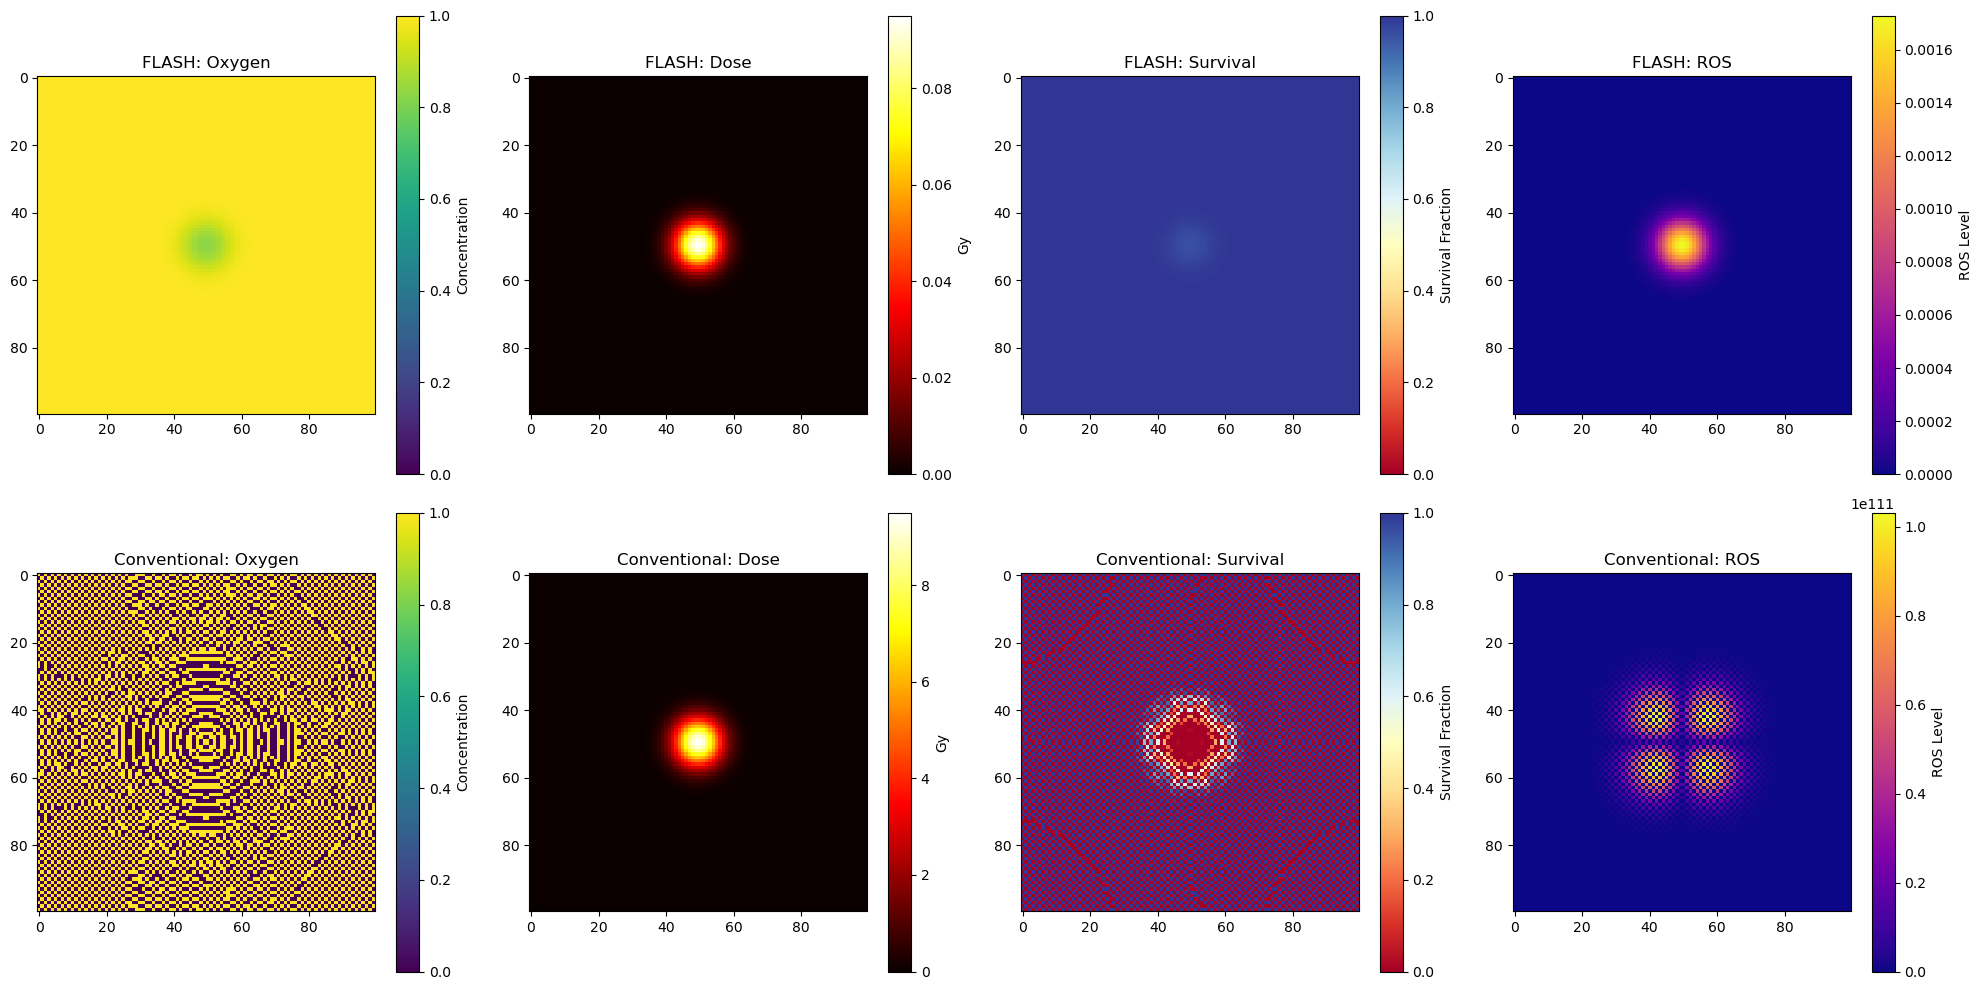

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

class FLASHRadiationSimulator:
    def __init__(self):
        # Physical parameters
        self.dose_rate_flash = 1000.0    # Gy/s for FLASH
        self.dose_rate_conv = 0.1        # Gy/s for conventional
        self.pulse_duration = 1e-6       # seconds
        self.oxygen_diffusion = 0.1      # mm²/s
        self.initial_oxygen = 1.0        # normalized
        self.oxygen_replenishment = 0.05  # rate
        
        # Grid parameters
        self.grid_size = 100
        self.tissue_size = 10.0  # mm
        self.dx = self.tissue_size / self.grid_size
        
        # ROS parameters
        self.ros_production_rate = 0.1
        self.ros_decay_rate = 0.2
        self.ros_diffusion = 0.05
        
        # Initialize grids
        self.x = np.linspace(-self.tissue_size/2, self.tissue_size/2, self.grid_size)
        self.y = np.linspace(-self.tissue_size/2, self.tissue_size/2, self.grid_size)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
        self.reset_tissue()

    def reset_tissue(self):
        """Reset tissue to initial conditions"""
        self.oxygen = self.initial_oxygen * np.ones((self.grid_size, self.grid_size))
        self.cumulative_dose = np.zeros((self.grid_size, self.grid_size))
        self.cell_survival = np.ones((self.grid_size, self.grid_size))
        self.ros_concentration = np.zeros((self.grid_size, self.grid_size))

    def calculate_oxygen_step(self, dt: float, beam_profile: np.ndarray, is_flash: bool):
        """Calculate oxygen dynamics for one time step"""
        if is_flash:
            oxygen_consumption = 2.0 * self.dose_rate_flash * dt * beam_profile * self.oxygen
            oxygen_recovery = self.oxygen_replenishment * dt * (1.0 - self.oxygen) * 0.1
        else:
            oxygen_consumption = 0.2 * self.dose_rate_conv * dt * beam_profile * self.oxygen
            oxygen_recovery = self.oxygen_replenishment * dt * (1.0 - self.oxygen)

        dx2 = self.dx * self.dx
        laplacian = (np.roll(self.oxygen, 1, 0) + np.roll(self.oxygen, -1, 0) +
                    np.roll(self.oxygen, 1, 1) + np.roll(self.oxygen, -1, 1) -
                    4 * self.oxygen) / dx2

        self.oxygen += (self.oxygen_diffusion * laplacian * dt - 
                       oxygen_consumption + oxygen_recovery)
        self.oxygen = np.clip(self.oxygen, 0, self.initial_oxygen)

    def calculate_ros_step(self, dt: float, dose_increment: np.ndarray, is_flash: bool):
        """Calculate ROS dynamics for one time step"""
        if is_flash:
            ros_prod = self.ros_production_rate * dose_increment * self.oxygen * 0.2
        else:
            ros_prod = self.ros_production_rate * dose_increment * self.oxygen

        dx2 = self.dx * self.dx
        laplacian = (np.roll(self.ros_concentration, 1, 0) + 
                    np.roll(self.ros_concentration, -1, 0) +
                    np.roll(self.ros_concentration, 1, 1) + 
                    np.roll(self.ros_concentration, -1, 1) -
                    4 * self.ros_concentration) / dx2

        self.ros_concentration += (self.ros_diffusion * laplacian * dt + ros_prod -
                                 self.ros_decay_rate * self.ros_concentration * dt)
        self.ros_concentration = np.maximum(0, self.ros_concentration)

    def calculate_survival(self, is_flash: bool):
        """Calculate cell survival"""
        alpha = 0.3
        beta = 0.03
        oer = 1 + 3 * self.oxygen / (self.oxygen + 0.1)
        flash_factor = 0.4 if is_flash else 1.0
        ros_effect = 1 + 0.2 * self.ros_concentration
        
        effective_dose = self.cumulative_dose * oer * flash_factor * ros_effect
        self.cell_survival = np.exp(-(alpha * effective_dose + 
                                    beta * effective_dose * effective_dose))

    def simulate_treatment(self, total_dose: float, is_flash: bool = True, 
                         beam_size: float = 2.0) -> Dict:
        """Simulate complete treatment"""
        dose_rate = self.dose_rate_flash if is_flash else self.dose_rate_conv
        treatment_type = "FLASH" if is_flash else "Conventional"
        
        self.reset_tissue()
        
        # Time steps
        if is_flash:
            n_steps = 100
            dt = self.pulse_duration
        else:
            n_steps = 100
            dt = total_dose / (dose_rate * n_steps)

        # Create beam profile
        beam_sigma = beam_size / 4
        beam_profile = np.exp(-(self.X**2 + self.Y**2)/(2*beam_sigma**2))
        
        # Store history
        history = {
            'oxygen': [],
            'dose': [],
            'survival': [],
            'ros': []
        }
        
        print(f"\nSimulating {treatment_type} treatment...")
        print(f"Total dose: {total_dose:.1f} Gy")
        print(f"Dose rate: {dose_rate:.1f} Gy/s")
        
        for step in range(n_steps):
            if step % (n_steps//10) == 0:
                print(f"Progress: {step/n_steps*100:.0f}%")
            
            # Deliver dose
            dose_increment = dose_rate * dt * beam_profile
            self.cumulative_dose += dose_increment
            
            # Calculate dynamics
            self.calculate_oxygen_step(dt, beam_profile, is_flash)
            self.calculate_ros_step(dt, dose_increment, is_flash)
            self.calculate_survival(is_flash)
            
            # Store state periodically
            if step % (n_steps//20) == 0:
                history['oxygen'].append(self.oxygen.copy())
                history['dose'].append(self.cumulative_dose.copy())
                history['survival'].append(self.cell_survival.copy())
                history['ros'].append(self.ros_concentration.copy())
        
        print("Simulation complete!")
        return history

    def plot_comparison(self, history_flash: Dict, history_conv: Dict):
        """Plot comparison"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        # Common parameters
        oxygen_kwargs = {'vmin': 0, 'vmax': self.initial_oxygen, 'cmap': 'viridis'}
        dose_kwargs = {'vmin': 0, 'vmax': None, 'cmap': 'hot'}
        survival_kwargs = {'vmin': 0, 'vmax': 1, 'cmap': 'RdYlBu'}
        ros_kwargs = {'vmin': 0, 'vmax': None, 'cmap': 'plasma'}
        
        # FLASH results
        im1 = axes[0,0].imshow(history_flash['oxygen'][-1], **oxygen_kwargs)
        plt.colorbar(im1, ax=axes[0,0], label='Concentration')
        axes[0,0].set_title('FLASH: Oxygen')
        
        im2 = axes[0,1].imshow(history_flash['dose'][-1], **dose_kwargs)
        plt.colorbar(im2, ax=axes[0,1], label='Gy')
        axes[0,1].set_title('FLASH: Dose')
        
        im3 = axes[0,2].imshow(history_flash['survival'][-1], **survival_kwargs)
        plt.colorbar(im3, ax=axes[0,2], label='Survival Fraction')
        axes[0,2].set_title('FLASH: Survival')
        
        im4 = axes[0,3].imshow(history_flash['ros'][-1], **ros_kwargs)
        plt.colorbar(im4, ax=axes[0,3], label='ROS Level')
        axes[0,3].set_title('FLASH: ROS')
        
        # Conventional results
        im5 = axes[1,0].imshow(history_conv['oxygen'][-1], **oxygen_kwargs)
        plt.colorbar(im5, ax=axes[1,0], label='Concentration')
        axes[1,0].set_title('Conventional: Oxygen')
        
        im6 = axes[1,1].imshow(history_conv['dose'][-1], **dose_kwargs)
        plt.colorbar(im6, ax=axes[1,1], label='Gy')
        axes[1,1].set_title('Conventional: Dose')
        
        im7 = axes[1,2].imshow(history_conv['survival'][-1], **survival_kwargs)
        plt.colorbar(im7, ax=axes[1,2], label='Survival Fraction')
        axes[1,2].set_title('Conventional: Survival')
        
        im8 = axes[1,3].imshow(history_conv['ros'][-1], **ros_kwargs)
        plt.colorbar(im8, ax=axes[1,3], label='ROS Level')
        axes[1,3].set_title('Conventional: ROS')
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    simulator = FLASHRadiationSimulator()
    
    # Run simulations
    history_flash = simulator.simulate_treatment(total_dose=10, is_flash=True)
    history_conv = simulator.simulate_treatment(total_dose=10, is_flash=False)
    
    # Plot comparison
    simulator.plot_comparison(history_flash, history_conv)
    plt.show()

/global/homes/r/rvizarr/.conda/envs/cernroot/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


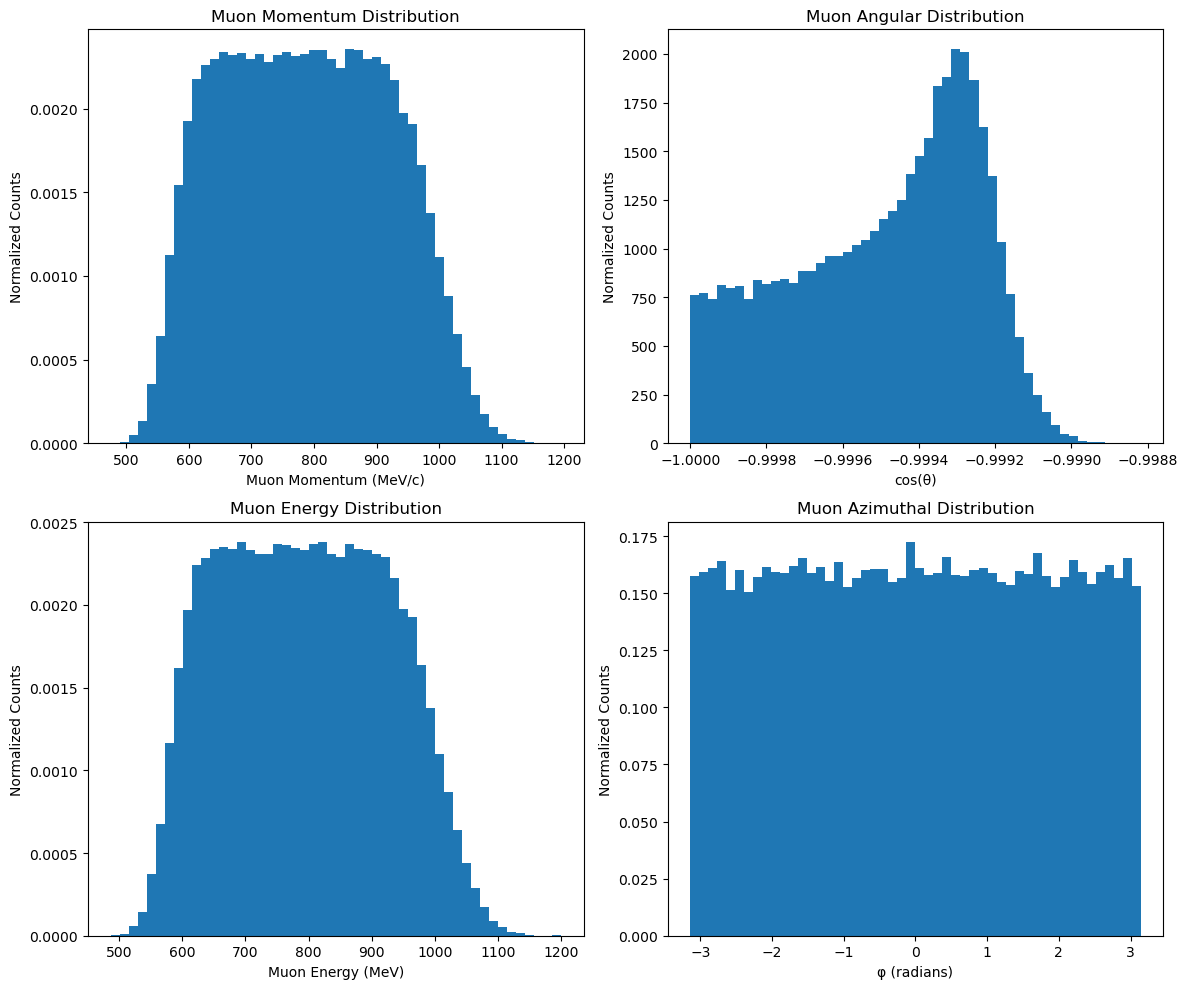

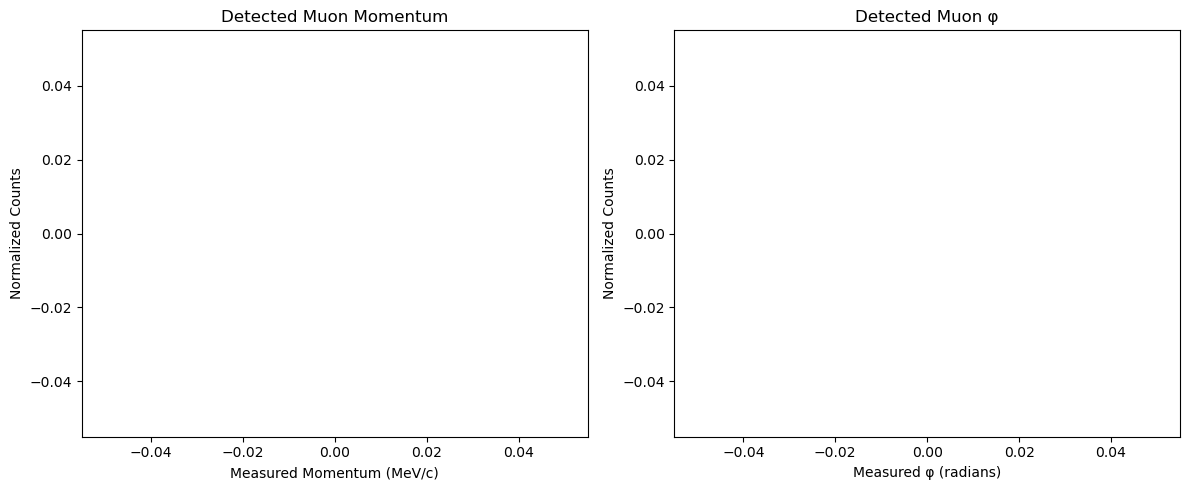

In [1]:
import numpy as np
from scipy.constants import c, hbar
import matplotlib.pyplot as plt

class ParticlePhysics:
    """Constants and utilities for particle physics calculations"""
    # Particle masses in MeV
    PION_MASS = 139.57039  # π± mass
    MUON_MASS = 105.6583755  # μ± mass
    
    # Pion lifetime in seconds
    PION_LIFETIME = 2.6033e-8
    
    @staticmethod
    def lorentz_boost(momentum, energy, px, py, pz, beta):
        """
        Apply Lorentz boost along z-axis
        
        Parameters:
        -----------
        momentum : array-like
            Particle momentum
        energy : array-like
            Particle energy
        px, py, pz : array-like
            Momentum components
        beta : float
            Velocity in units of c
        
        Returns:
        --------
        tuple: (E', px', py', pz') in boosted frame
        """
        gamma = 1 / np.sqrt(1 - beta**2)
        
        # Boost matrix multiplication
        e_prime = gamma * (energy - beta * pz)
        pz_prime = gamma * (pz - beta * energy)
        
        return e_prime, px, py, pz_prime

class PionDecaySimulation:
    """Simulation of π± → μ± + νμ decay"""
    
    def __init__(self, n_events=10000):
        self.physics = ParticlePhysics()
        self.n_events = n_events
        
        # Initialize arrays for final state particles
        self.muon_momentum = np.zeros(n_events)
        self.muon_energy = np.zeros(n_events)
        self.muon_theta = np.zeros(n_events)
        self.muon_phi = np.zeros(n_events)
        
        self.neutrino_momentum = np.zeros(n_events)
        self.neutrino_energy = np.zeros(n_events)
        
    def generate_pion_beam(self, mean_momentum=1000.0, momentum_spread=50.0):
        """
        Generate initial pion beam
        
        Parameters:
        -----------
        mean_momentum : float
            Mean pion momentum in MeV/c
        momentum_spread : float
            Gaussian spread in momentum (MeV/c)
        """
        # Generate pion momenta
        self.pion_momentum = np.random.normal(mean_momentum, momentum_spread, self.n_events)
        self.pion_energy = np.sqrt(self.pion_momentum**2 + self.physics.PION_MASS**2)
        self.pion_beta = self.pion_momentum / self.pion_energy
        self.pion_gamma = 1 / np.sqrt(1 - self.pion_beta**2)
        
    def decay_pions_rest_frame(self):
        """Calculate decay products in pion rest frame"""
        # Fixed energies in rest frame (two-body decay)
        m_pi = self.physics.PION_MASS
        m_mu = self.physics.MUON_MASS
        
        # Calculate energies in rest frame
        self.muon_energy_rest = (m_pi**2 + m_mu**2) / (2 * m_pi)
        self.neutrino_energy_rest = (m_pi**2 - m_mu**2) / (2 * m_pi)
        
        # Calculate momenta in rest frame
        self.muon_momentum_rest = np.sqrt(self.muon_energy_rest**2 - m_mu**2)
        self.neutrino_momentum_rest = self.neutrino_energy_rest  # massless neutrino
        
        # Generate isotropic angles
        cos_theta = np.random.uniform(-1, 1, self.n_events)
        phi = np.random.uniform(0, 2*np.pi, self.n_events)
        
        # Calculate momentum components in rest frame
        sin_theta = np.sqrt(1 - cos_theta**2)
        self.muon_px_rest = self.muon_momentum_rest * sin_theta * np.cos(phi)
        self.muon_py_rest = self.muon_momentum_rest * sin_theta * np.sin(phi)
        self.muon_pz_rest = self.muon_momentum_rest * cos_theta
        
    def boost_to_lab(self):
        """Transform decay products to lab frame"""
        for i in range(self.n_events):
            # Boost muon to lab frame
            e_prime, px_prime, py_prime, pz_prime = self.physics.lorentz_boost(
                self.muon_momentum_rest,
                self.muon_energy_rest,
                self.muon_px_rest[i],
                self.muon_py_rest[i],
                self.muon_pz_rest[i],
                self.pion_beta[i]
            )
            
            # Store lab frame quantities
            self.muon_energy[i] = e_prime
            p_transverse = np.sqrt(px_prime**2 + py_prime**2)
            self.muon_momentum[i] = np.sqrt(p_transverse**2 + pz_prime**2)
            self.muon_theta[i] = np.arctan2(p_transverse, pz_prime)
            self.muon_phi[i] = np.arctan2(py_prime, px_prime)
    
    def run_simulation(self):
        """Execute full simulation chain"""
        self.generate_pion_beam()
        self.decay_pions_rest_frame()
        self.boost_to_lab()
    
    def plot_results(self):
        """Generate plots of simulation results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Muon momentum distribution
        ax1.hist(self.muon_momentum, bins=50, density=True)
        ax1.set_xlabel('Muon Momentum (MeV/c)')
        ax1.set_ylabel('Normalized Counts')
        ax1.set_title('Muon Momentum Distribution')
        
        # Muon angular distribution
        ax2.hist(np.cos(self.muon_theta), bins=50, density=True)
        ax2.set_xlabel('cos(θ)')
        ax2.set_ylabel('Normalized Counts')
        ax2.set_title('Muon Angular Distribution')
        
        # Muon energy distribution
        ax3.hist(self.muon_energy, bins=50, density=True)
        ax3.set_xlabel('Muon Energy (MeV)')
        ax3.set_ylabel('Normalized Counts')
        ax3.set_title('Muon Energy Distribution')
        
        # Muon phi distribution
        ax4.hist(self.muon_phi, bins=50, density=True)
        ax4.set_xlabel('φ (radians)')
        ax4.set_ylabel('Normalized Counts')
        ax4.set_title('Muon Azimuthal Distribution')
        
        plt.tight_layout()
        return fig

class DetectorSimulation:
    """Simplified detector response simulation"""
    
    def __init__(self, eta_max=2.5, phi_resolution=0.1, p_resolution_const=0.02,
                 p_resolution_term=0.005):
        self.eta_max = eta_max
        self.phi_resolution = phi_resolution
        self.p_resolution_const = p_resolution_const  # Constant term
        self.p_resolution_term = p_resolution_term    # p-dependent term
        
    def apply_acceptance(self, decay_sim):
        """Apply detector acceptance cuts"""
        # Convert theta to eta
        eta = -np.log(np.tan(decay_sim.muon_theta / 2))
        
        # Basic acceptance cut
        self.accepted = np.abs(eta) < self.eta_max
        
        # Apply detector resolutions
        n_accepted = np.sum(self.accepted)
        self.measured_p = np.zeros(n_accepted)
        self.measured_phi = np.zeros(n_accepted)
        
        # Get accepted particles
        accepted_p = decay_sim.muon_momentum[self.accepted]
        accepted_phi = decay_sim.muon_phi[self.accepted]
        
        # Apply momentum resolution
        p_resolution = np.sqrt(self.p_resolution_const**2 + 
                             (self.p_resolution_term * accepted_p)**2)
        self.measured_p = np.random.normal(accepted_p, p_resolution * accepted_p)
        
        # Apply phi resolution
        self.measured_phi = np.random.normal(accepted_phi, self.phi_resolution)
        
    def plot_detector_response(self):
        """Plot detector response distributions"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Momentum resolution
        ax1.hist(self.measured_p, bins=50, density=True)
        ax1.set_xlabel('Measured Momentum (MeV/c)')
        ax1.set_ylabel('Normalized Counts')
        ax1.set_title('Detected Muon Momentum')
        
        # Phi resolution
        ax2.hist(self.measured_phi, bins=50, density=True)
        ax2.set_xlabel('Measured φ (radians)')
        ax2.set_ylabel('Normalized Counts')
        ax2.set_title('Detected Muon φ')
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Create and run decay simulation
    decay_sim = PionDecaySimulation(n_events=100000)
    decay_sim.run_simulation()
    
    # Create and run detector simulation
    det_sim = DetectorSimulation()
    det_sim.apply_acceptance(decay_sim)
    
    # Plot results
    decay_sim.plot_results()
    det_sim.plot_detector_response()
    plt.show()

Analytical Checks:
1. Fixed rest frame quantities:
   Muon energy: 109.78 MeV
   Muon momentum: 29.79 MeV/c
   Neutrino energy: 29.79 MeV

2. Conservation laws (first event):
   Rest frame total energy: 139.57 MeV
   Should equal pion mass: 139.57 MeV

   Total z-momentum: 1056.13 MeV/c
   Initial pion momentum: 1056.13 MeV/c


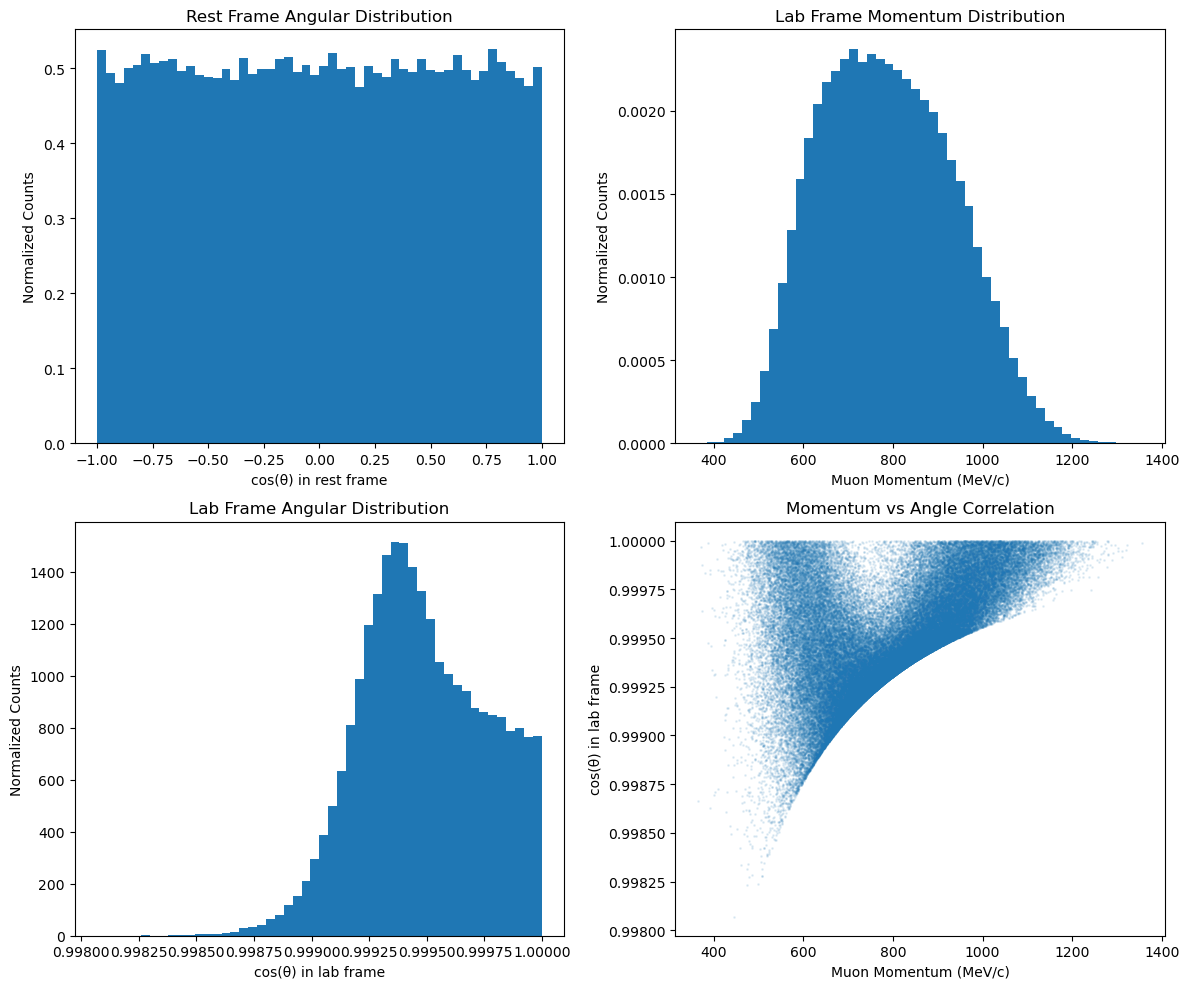

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class PionDecayKinematics:
    """
    Simulates π+ → μ+ + νμ decay kinematics
    """
    def __init__(self):
        # Particle masses in MeV
        self.M_PION = 139.57039  # π± mass
        self.M_MUON = 105.6583755  # μ± mass
        self.M_NEUTRINO = 0.0  # Treating neutrino as massless
        
        # Calculate fixed quantities in pion rest frame
        self.E_mu_rest = (self.M_PION**2 + self.M_MUON**2)/(2*self.M_PION)
        self.E_nu_rest = (self.M_PION**2 - self.M_MUON**2)/(2*self.M_PION)
        self.p_mu_rest = np.sqrt(self.E_mu_rest**2 - self.M_MUON**2)
        
    def generate_pion_beam(self, n_events, mean_p=1000, sigma_p=100):
        """Generate pion beam with Gaussian momentum distribution"""
        self.n_events = n_events
        self.pion_p = np.random.normal(mean_p, sigma_p, n_events)
        self.pion_E = np.sqrt(self.pion_p**2 + self.M_PION**2)
        self.pion_gamma = self.pion_E/self.M_PION
        self.pion_beta = self.pion_p/self.pion_E
        
        return self.pion_p, self.pion_E
    
    def decay_in_rest_frame(self):
        """Generate isotropic decays in pion rest frame"""
        # Uniform cos(theta) distribution for isotropic decay
        cos_theta = np.random.uniform(-1, 1, self.n_events)
        phi = np.random.uniform(0, 2*np.pi, self.n_events)
        sin_theta = np.sqrt(1 - cos_theta**2)
        
        # Muon momentum components in rest frame
        self.mu_px_rest = self.p_mu_rest * sin_theta * np.cos(phi)
        self.mu_py_rest = self.p_mu_rest * sin_theta * np.sin(phi)
        self.mu_pz_rest = self.p_mu_rest * cos_theta
        
        # Store angles for analysis
        self.theta = np.arccos(cos_theta)
        self.phi = phi
        
        return self.mu_px_rest, self.mu_py_rest, self.mu_pz_rest
    
    def boost_to_lab(self):
        """Boost particles to lab frame"""
        # Arrays for lab frame quantities
        self.mu_E_lab = np.zeros(self.n_events)
        self.mu_px_lab = np.zeros(self.n_events)
        self.mu_py_lab = np.zeros(self.n_events)
        self.mu_pz_lab = np.zeros(self.n_events)
        
        # Perform boost for each event
        for i in range(self.n_events):
            # Lorentz boost matrix elements
            gamma = self.pion_gamma[i]
            beta = self.pion_beta[i]
            
            # Apply boost along z-axis
            self.mu_E_lab[i] = gamma * (self.E_mu_rest + 
                                      beta * self.mu_pz_rest[i])
            self.mu_px_lab[i] = self.mu_px_rest[i]
            self.mu_py_lab[i] = self.mu_py_rest[i]
            self.mu_pz_lab[i] = gamma * (self.mu_pz_rest[i] + 
                                       beta * self.E_mu_rest)
        
        # Calculate final muon momentum and angles
        self.mu_p_lab = np.sqrt(self.mu_px_lab**2 + 
                               self.mu_py_lab**2 + 
                               self.mu_pz_lab**2)
        self.mu_theta_lab = np.arccos(self.mu_pz_lab/self.mu_p_lab)
        
        return self.mu_p_lab, self.mu_theta_lab
    
    def run_simulation(self, n_events=10000, mean_p=1000, sigma_p=100):
        """Run complete simulation"""
        self.generate_pion_beam(n_events, mean_p, sigma_p)
        self.decay_in_rest_frame()
        self.boost_to_lab()
        
    def plot_distributions(self):
        """Create plots of key distributions"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        # Rest frame angular distribution
        ax1.hist(np.cos(self.theta), bins=50, density=True)
        ax1.set_xlabel('cos(θ) in rest frame')
        ax1.set_ylabel('Normalized Counts')
        ax1.set_title('Rest Frame Angular Distribution')
        
        # Lab frame momentum
        ax2.hist(self.mu_p_lab, bins=50, density=True)
        ax2.set_xlabel('Muon Momentum (MeV/c)')
        ax2.set_ylabel('Normalized Counts')
        ax2.set_title('Lab Frame Momentum Distribution')
        
        # Lab frame angle
        ax3.hist(np.cos(self.mu_theta_lab), bins=50, density=True)
        ax3.set_xlabel('cos(θ) in lab frame')
        ax3.set_ylabel('Normalized Counts')
        ax3.set_title('Lab Frame Angular Distribution')
        
        # 2D momentum vs angle
        scatter = ax4.scatter(self.mu_p_lab, np.cos(self.mu_theta_lab), 
                            alpha=0.1, s=1)
        ax4.set_xlabel('Muon Momentum (MeV/c)')
        ax4.set_ylabel('cos(θ) in lab frame')
        ax4.set_title('Momentum vs Angle Correlation')
        
        plt.tight_layout()
        return fig

    def analytical_checks(self):
        """Perform analytical checks on the simulation"""
        print("Analytical Checks:")
        print(f"1. Fixed rest frame quantities:")
        print(f"   Muon energy: {self.E_mu_rest:.2f} MeV")
        print(f"   Muon momentum: {self.p_mu_rest:.2f} MeV/c")
        print(f"   Neutrino energy: {self.E_nu_rest:.2f} MeV")
        
        print("\n2. Conservation laws (first event):")
        # Energy conservation in rest frame
        E_total_rest = self.E_mu_rest + self.E_nu_rest
        print(f"   Rest frame total energy: {E_total_rest:.2f} MeV")
        print(f"   Should equal pion mass: {self.M_PION:.2f} MeV")
        
        # Momentum conservation in lab frame
        p_total_z = self.mu_pz_lab[0] + (self.E_nu_rest * 
                    self.pion_gamma[0] * (self.pion_beta[0] + 
                    (-self.mu_pz_rest[0]/self.E_nu_rest)))
        print(f"\n   Total z-momentum: {p_total_z:.2f} MeV/c")
        print(f"   Initial pion momentum: {self.pion_p[0]:.2f} MeV/c")

# Example usage
if __name__ == "__main__":
    # Create simulator
    sim = PionDecayKinematics()
    
    # Run simulation
    sim.run_simulation(n_events=100000)
    
    # Check analytical constraints
    sim.analytical_checks()
    
    # Create plots
    sim.plot_distributions()
    plt.show()

In [3]:
# Convert angle to more practical units
theta_max = np.arccos(0.998)  # radians
theta_degrees = theta_max * (180/np.pi)  # ~ 3.6 degrees

# Calculate spread at some distance
distance = 1000  # mm
spread_radius = distance * np.tan(theta_max)  # mm

In [4]:
theta_degrees

3.62430749400795